Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset downloaded at: /kaggle/input/chest-xray-pneumonia
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


163/163 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.7883 - loss: 0.5069 - val_accuracy: 0.7500 - val_loss: 0.6994
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9498 - loss: 0.1374 - val_accuracy: 0.7500 - val_loss: 0.6305
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9606 - loss: 0.1164 - val_accuracy: 0.8125 - val_loss: 0.3217
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.9686 - loss: 0.0842 - val_accuracy: 0.9375 - val_loss: 0.2419
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.9755 - loss: 0.0790 - val_accuracy: 0.8750 - val_loss: 0.3005
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9768 - loss: 0.0661 - val_accuracy: 0.9375 - val_loss: 0.2138
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9792 - loss: 0.0532 - val_accuracy: 1.0000 - val_loss: 0.0565
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.9820 - loss: 0.0455 - val_accuracy: 0.937

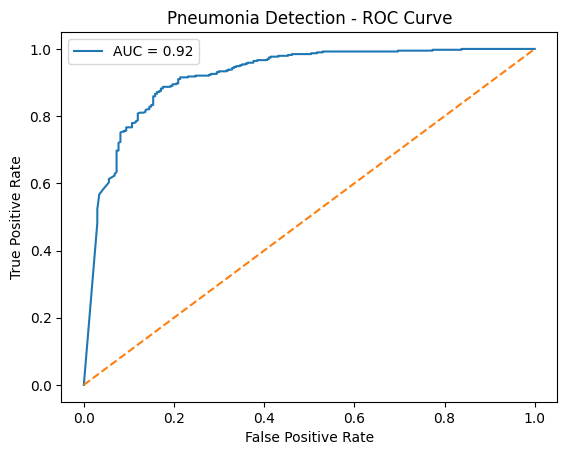

In [ ]:
# ==============================
# Week 3 - Project 2: Pneumonia Detection
# Internship - DevelopersHub Corporation
# ==============================

# 1. Install dependencies
!pip install kagglehub tensorflow matplotlib seaborn scikit-learn

import kagglehub, os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 2. Download Pneumonia Dataset
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset downloaded at:", dataset_path)

# Dataset already has train/val/test folders
img_size = (128,128)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "chest_xray/train"),
    image_size=img_size,
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "chest_xray/val"),
    image_size=img_size,
    batch_size=batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(dataset_path, "chest_xray/test"),
    image_size=img_size,
    batch_size=batch_size
)

# Normalize
normalization = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization(x),y))
val_ds = val_ds.map(lambda x,y: (normalization(x),y))
test_ds = test_ds.map(lambda x,y: (normalization(x),y))

# 3. Build Simple CNN Model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# 4. Train
history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=10)

# 5. Evaluate with ROC Curve
y_true, y_pred = [], []
for x, y in test_ds:
    preds = cnn_model.predict(x)
    y_true.extend(y.numpy())
    y_pred.extend(preds.flatten())

fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Pneumonia Detection - ROC Curve")
plt.show()

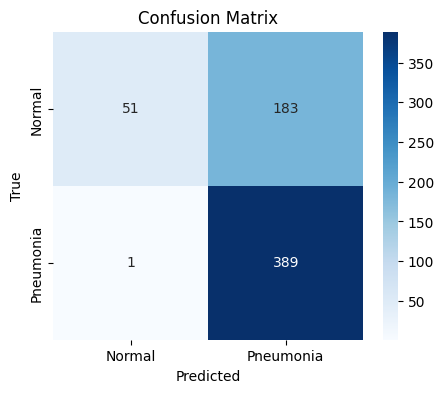

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.22      0.36       234
   Pneumonia       0.68      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.61      0.58       624
weighted avg       0.79      0.71      0.64       624



In [4]:
# 6. Confusion Matrix, Precision, Recall, F1-score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Convert predictions to binary (0 = Normal, 1 = Pneumonia)
y_pred_labels = np.where(np.array(y_pred) > 0.5, 1, 0)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (Precision, Recall, F1, Accuracy)
print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=["Normal", "Pneumonia"]))